In [228]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [229]:
import nswe_wbmuscl2 as wb2

# Lake at rest

From Berthon y Marche (2008), section 6.3.

The topography is defined by

$$ d(x,y)  = \begin{cases}
0.2 - 0.05(x-10)^2 & \text{ if } 8m < x < 12m \\
0 & \text{ else}
\end{cases}$$

and the water level is set to $0.1m$

In [230]:
nt = 20
nx = 100
cfl = 1.0

In [231]:
x = np.linspace(0,25,nx)
dx = np.diff(x)[0]
d0 = np.where((x>8)*(x<12), 0.2-0.05*(x-10.)**2, 0.0)
h0 = np.where(0.1-d0>=0, 0.1-d0, 0.0)
hu0 = np.zeros_like(h0)

* Initial condition

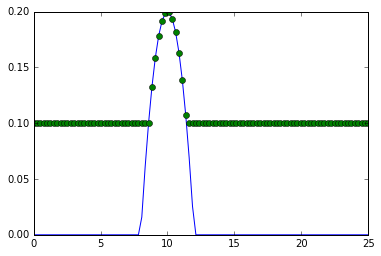

In [232]:
plt.plot(x,d0)
plt.plot(x,h0+d0,'o')

In [233]:
t,h,hu = wb2.sim_rk4(h0, hu0, d0, nt, nx, cfl, dx, wb2.bcs_open, hmin=0.0)

* Difference between computed solution and initial condition 

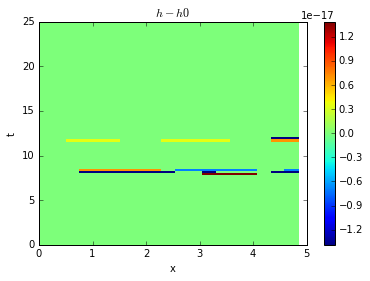

In [234]:
tax, xax = np.meshgrid(t,x)
plt.pcolormesh(tax.T,xax.T,np.array([h[i,2:-2]-h[0,2:-2] for i in range(h.shape[0])]))
plt.colorbar()
plt.title(r'$h - h0$')
plt.xlabel('x')
plt.ylabel('t')

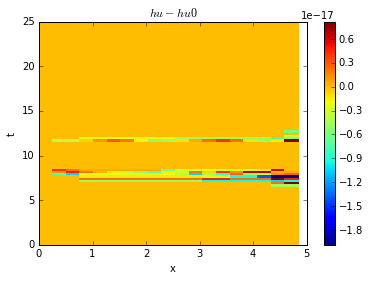

In [235]:
plt.pcolormesh(tax.T,xax.T,np.array([hu[i,2:-2]-hu[0,2:-2] for i in range(h.shape[0])]))
plt.colorbar()
plt.title(r'$hu - hu0$')
plt.xlabel('x')
plt.ylabel('t')

* Animation of the simulation


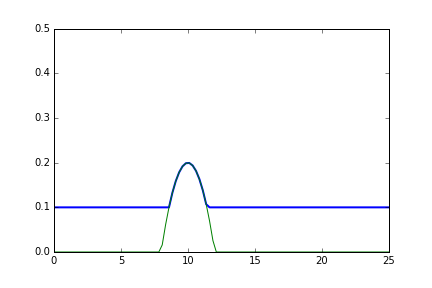
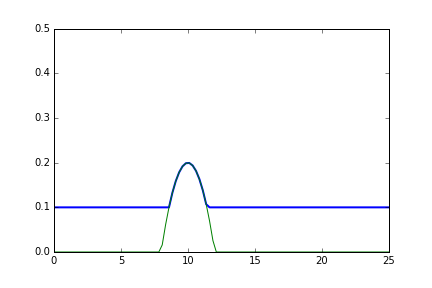
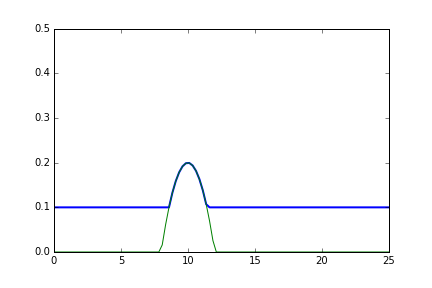
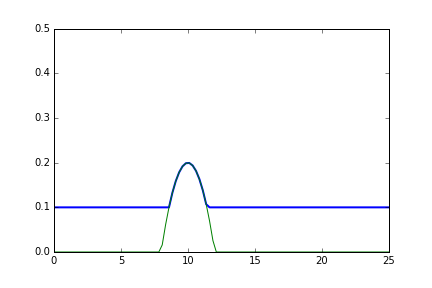
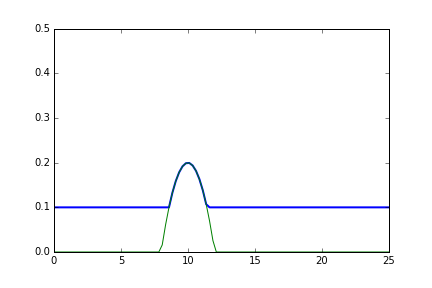
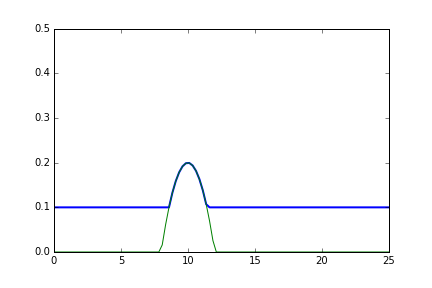
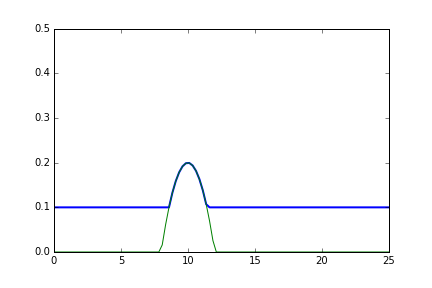
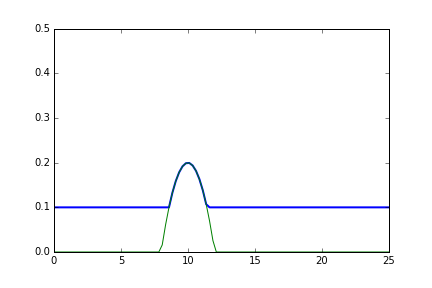
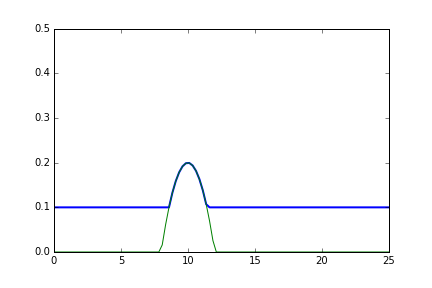
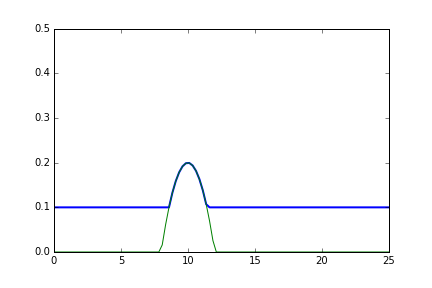
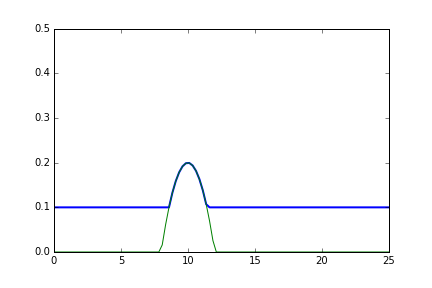
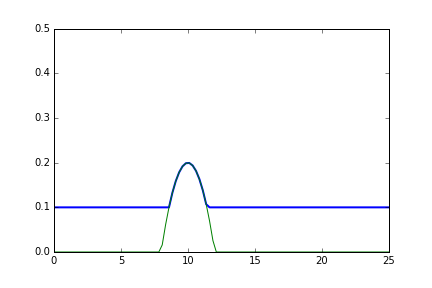
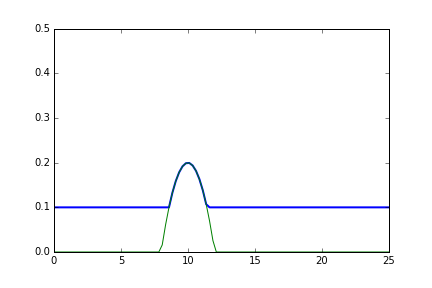
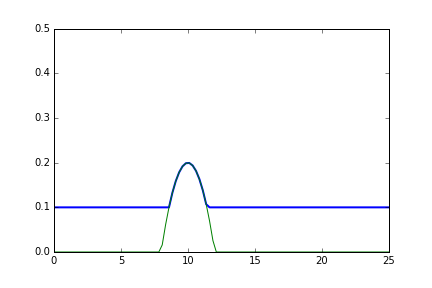
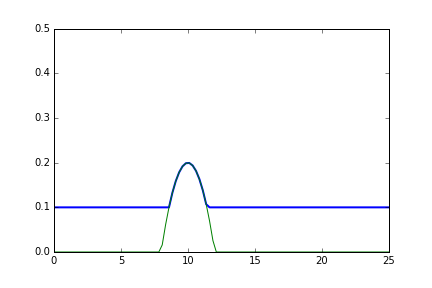
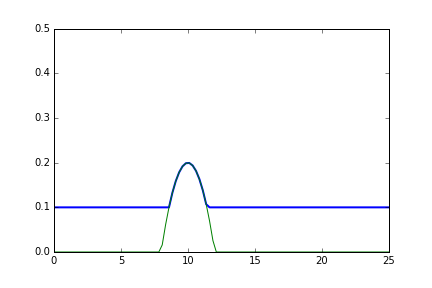
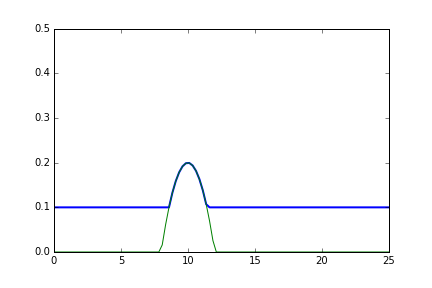
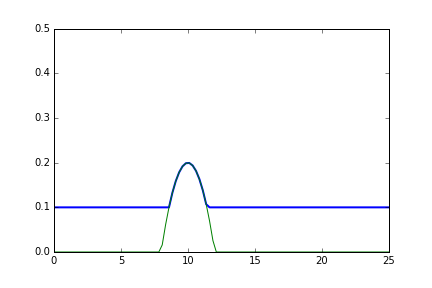
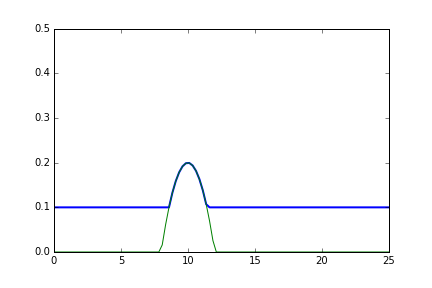

In [236]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 25), ylim=(0.0,0.5))
line, = ax.plot([], [], lw=2)
lineb, = ax.plot(x,d0)

def animate(i):
    line.set_data(x, h[i,2:-2]+d0)
    return line,

animation.FuncAnimation(fig, animate, frames=nt-1, interval=45)

# Sinusoidal wave propagation in shallow water

The boundary condition is defined as follows:

Given $h_b(t)$ the water height at the boundary, the value to use in the first ghost cell is $$h_L = h_b(t+\Delta t)$$ and for $hu$ is $$(hu)_L = c_0 (h_L-h_0)$$ with $h_0$ the mean water level.

In [237]:
def bcs_inwave_open(d,h0,hu0,href,hwave,t,dt):
    """ 
        incident wave height at the left boundary
        open at the right boundary
    """
    hl  = hwave(t+dt)
    hul = np.sqrt(9.81*href)*(hl-href)
    ul = hul/hl
    hr = h0[2]
    hur = hu0[2]
    ur = hur/hr    
    
    Rlplus = ul + 2.*np.sqrt(9.81*hl)
    Rrminus = ur - 2.*np.sqrt(9.81*hr)
    
    ua = 0.5*(Rlplus + Rrminus)
    ha = 1./(16.*9.81)*(Rlplus-Rrminus)**2
    
    db = 1.*d
    hb = 1.*h0
    hub = 1.*hu0
    db[0] = db[2]
    db[1] = db[2]
    hb[0] = ha
    hb[1] = ha
    hub[0] = ha*ua
    hub[1] = ha*ua
    
    db[-1] = db[-4]
    db[-2] = db[-3]
    hb[-1] = hb[-4]
    hb[-2] = hb[-3]
    hub[-1] = hub[-4]    
    hub[-2] = hub[-3]    
    return db,hb,hub

In [238]:
nt = 100
nx = 50
cfl = 1.0

(0, 11)

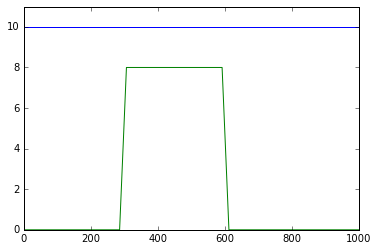

In [239]:
x = np.linspace(0,1000,nx)
H0 = 10.
T = 0.5
a = 1.0

d0 = np.where((x<=600.)*(x>=300), H0*0.8,0.0)
h0 = H0-d0
hu0 = np.zeros_like(x)
plt.plot(x,h0+d0)
plt.plot(x,d0)
plt.ylim(0,11)

In [240]:
def sinwave(t):
    return np.sin(t/T*2.*np.pi)*a+H0

In [241]:
t, h,hu = wb2.sim_rk4(h0, hu0, d0, nt, nx, cfl, dx, bcs=bcs_inwave_open, bcargs=[H0,sinwave], hmin=1e-5)


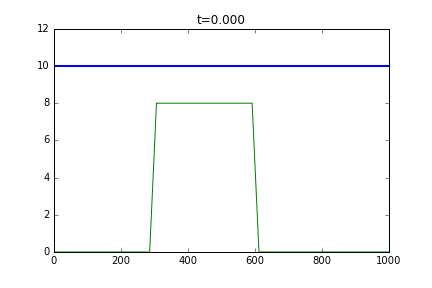
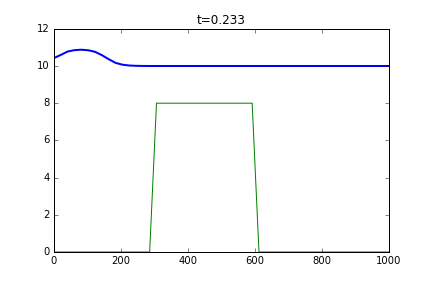
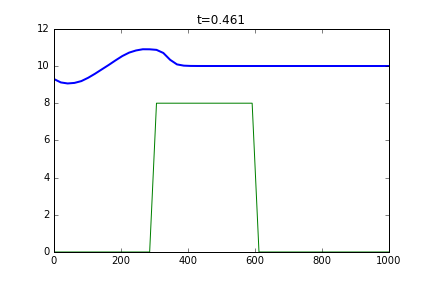
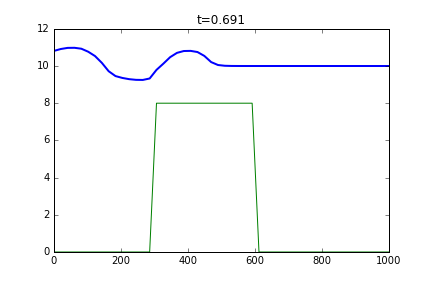
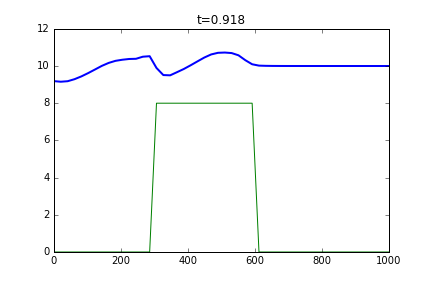
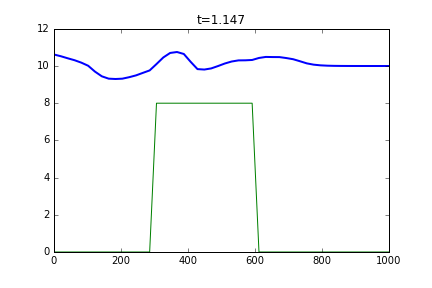
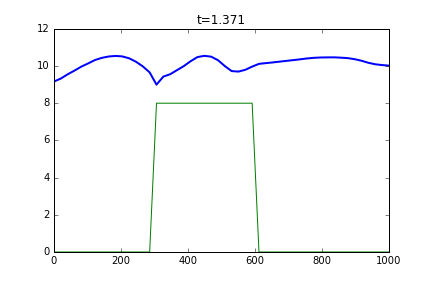
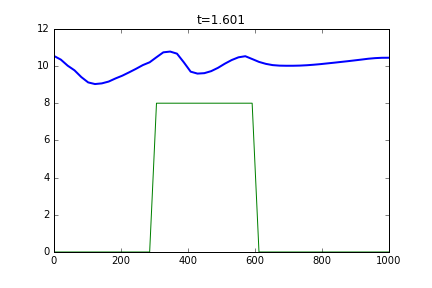
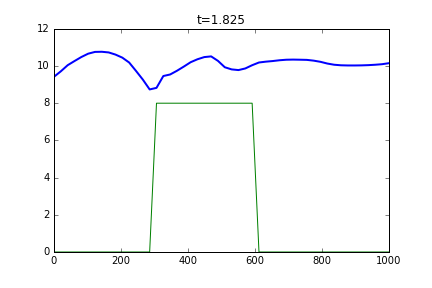
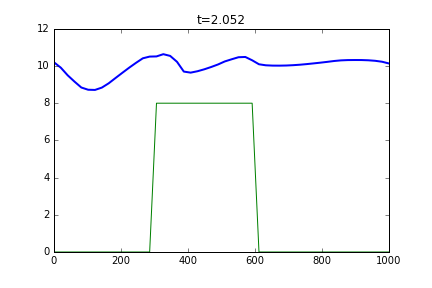

In [242]:
fig = plt.figure()
ax = plt.axes(xlim=(0, x.max()), ylim=(0.0,H0+2.*a))
line, = ax.plot([], [], lw=2)
lineb, = ax.plot(x,d0)
tt = ax.set_title('t')
def animate(i):
    i = min(nt,i*10)
    line.set_data(x, h[i,2:-2]+d0)
    tt.set_text('t=%.3f'%t[i])
    return line,

animation.FuncAnimation(fig, animate, frames=nt/10, interval=45)

# Subcritical flow over a bump

Given $q_b(t)$ the water flow at the boundary, the value to use in the first ghost cell is $$hu_L = q_b(t+\Delta t)$$ and the water height is $$h_L = h_0 + \frac{q_L}{c_0}$$


In [243]:
def bcs_inflow(d,h0,hu0,hin,qin,t,dt):
    """ 
        incident wave height at the left boundary
        open at the right boundary
    """
    hl  = qin/hin
    hul = qin
    ul = hul/hl
    hr = h0[2]
    hur = hu0[2]
    ur = hur/hr    
    
    Rlplus = ul + 2.*np.sqrt(9.81*hl)
    Rrminus = ur - 2.*np.sqrt(9.81*hr)
    
    ua = 0.5*(Rlplus + Rrminus)
    ha = 1./(16.*9.81)*(Rlplus-Rrminus)**2
    
    db = 1.*d
    hb = 1.*h0
    hub = 1.*hu0
    db[0] = db[2]
    db[1] = db[2]
    hb[0] = ha
    hb[1] = ha
    hub[0] = ha*ua
    hub[1] = ha*ua
    
    
    hr = hin
    hur = 0.0
    hl = h0[-3]
    hul = hu0[-3]
    ul = hul/hl

    Rlplus = ul + 2.*np.sqrt(9.81*hl)
    Rrminus = ur - 2.*np.sqrt(9.81*hr)

    ua = 0.5*(Rlplus + Rrminus)
    ha = 1./(16.*9.81)*(Rlplus-Rrminus)**2
    
    db[-1] = db[-4]
    db[-2] = db[-4]
    hb[-1] = ha
    hb[-2] = ha
    hub[-1] = ha*ua
    hub[-2] = ha*ua
    
    return db,hb,hub

(0, 2.1)

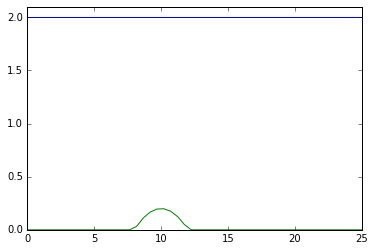

In [244]:
nt = 100
nx = 50
H0 = 2.
q0 = 4.42
x = np.linspace(0,25,50)
d0 = np.where((x<=12.)*(x>=8), 0.2-0.05*(x-10.)**2,0.0)
h0 = H0-d0
hu0 = np.ones_like(x)*4.42
plt.plot(x,h0+d0)
plt.plot(x,d0)
plt.ylim(0,2.1)

In [245]:
tw, hw,huw = wb2.sim_rk4(h0, hu0, d0, nt*4, nx, cfl, dx, bcs=bcs_inflow, bcargs=[H0,q0])


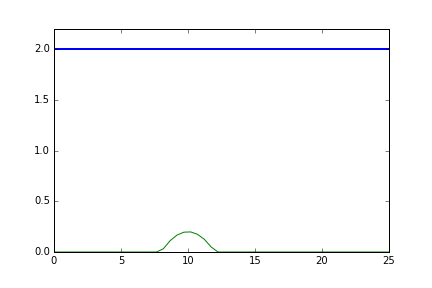
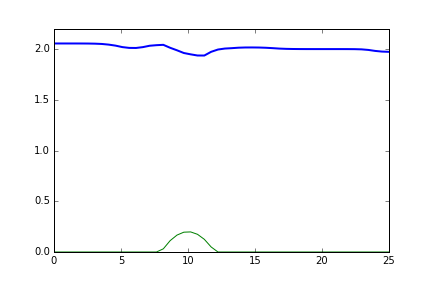
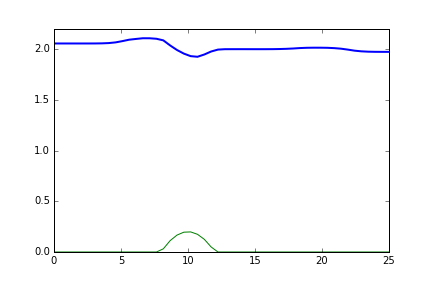
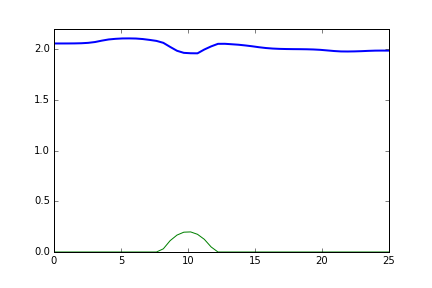
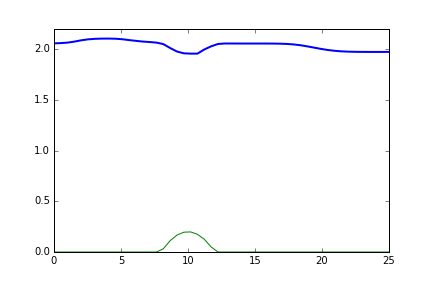
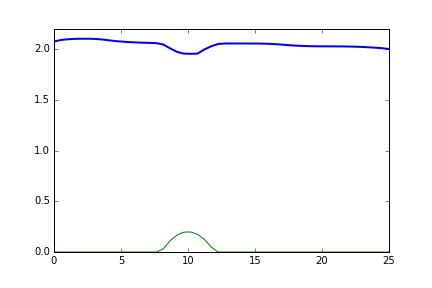
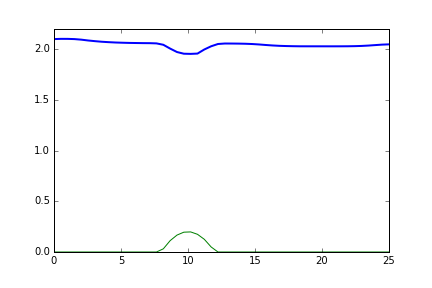
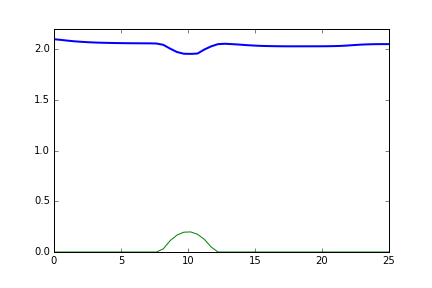
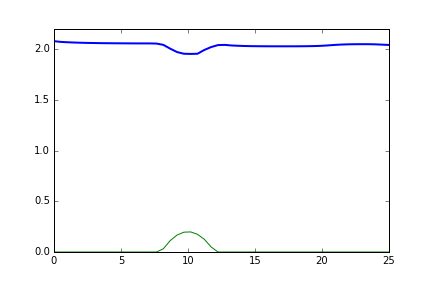
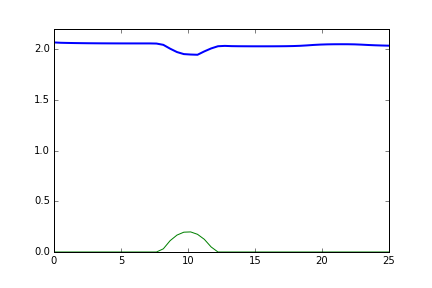
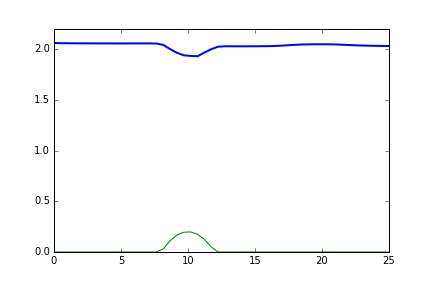
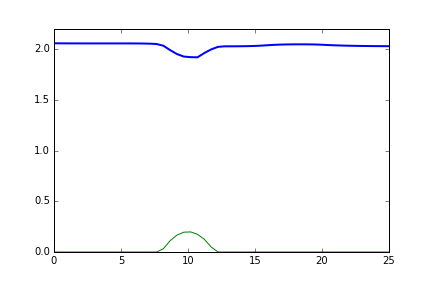
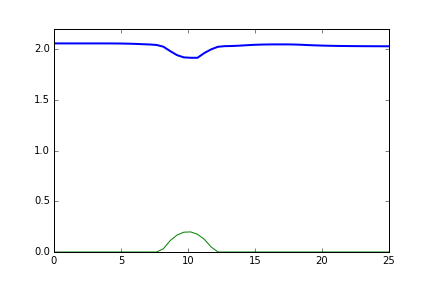
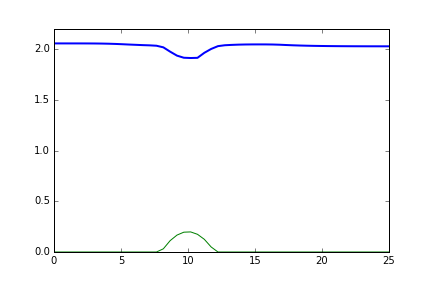
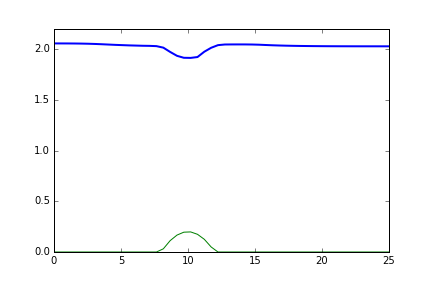
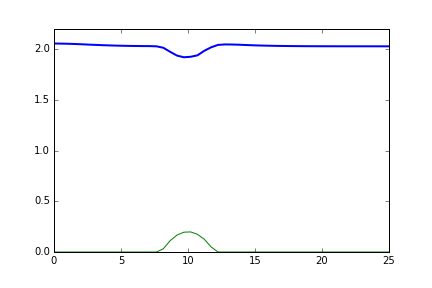
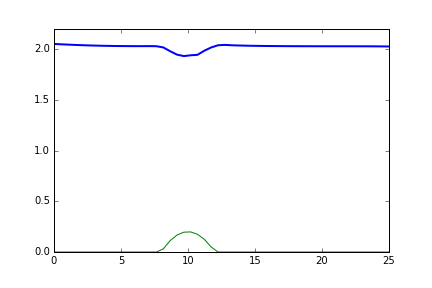
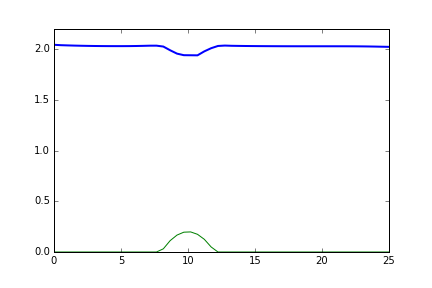
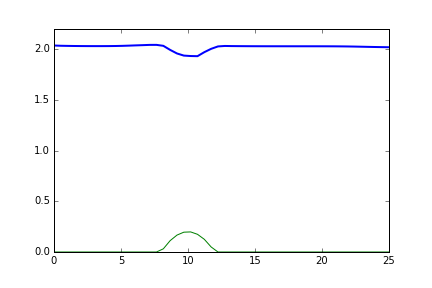
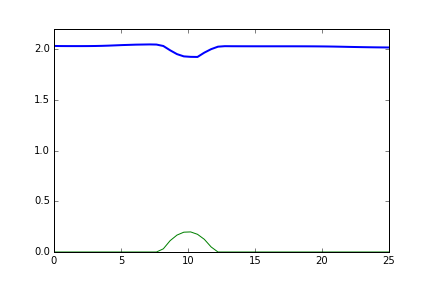
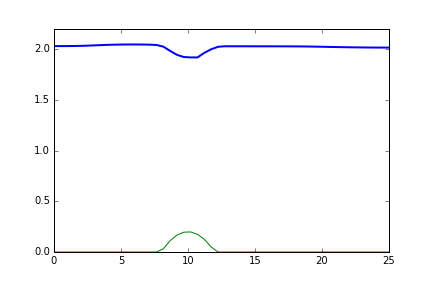
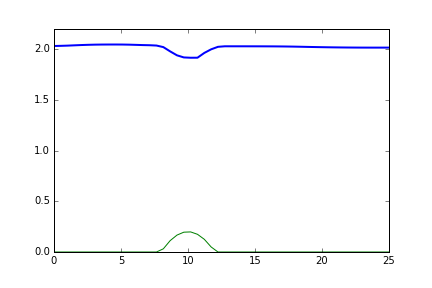
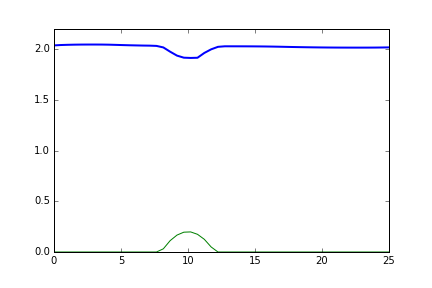
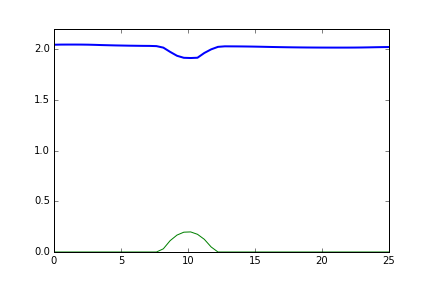
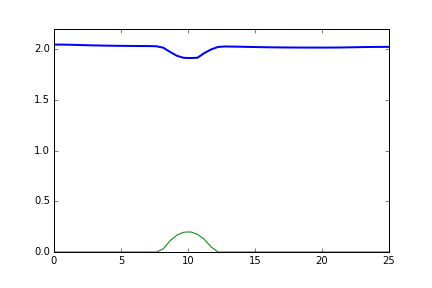
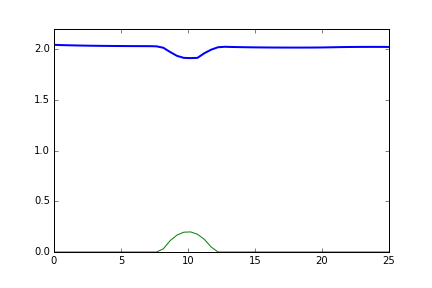
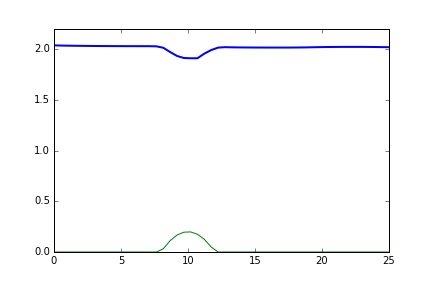
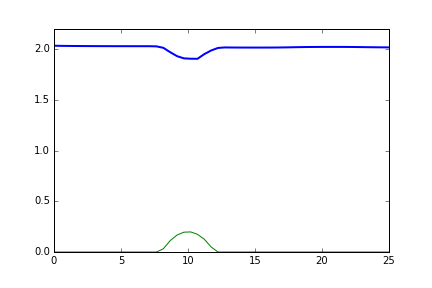
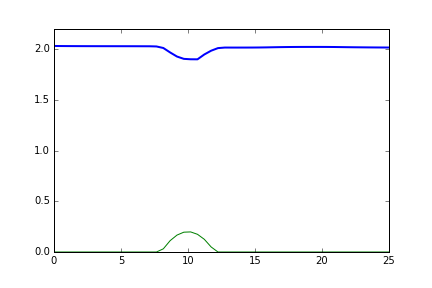
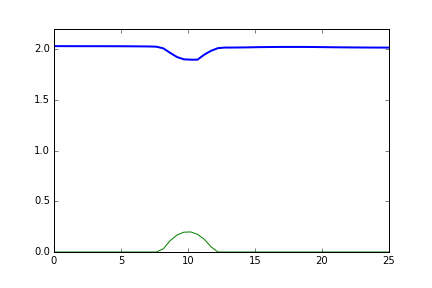
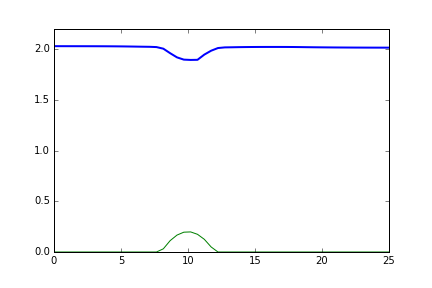
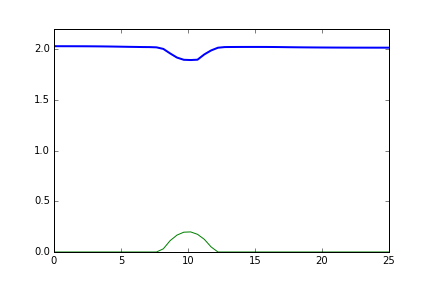
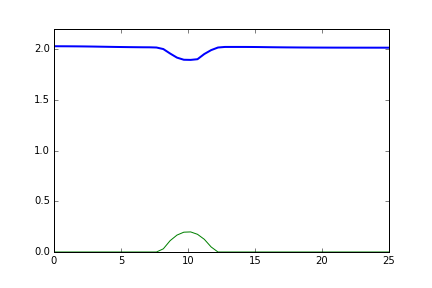
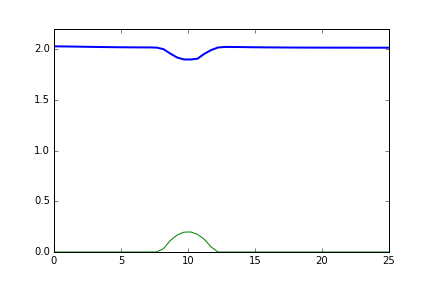
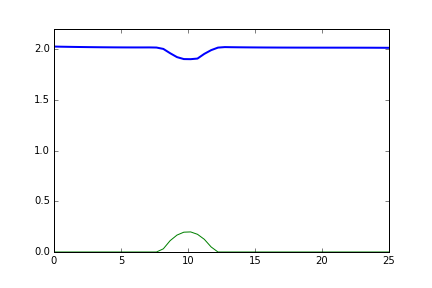
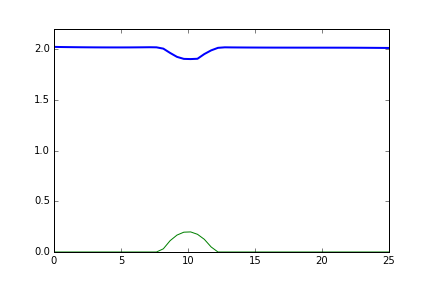
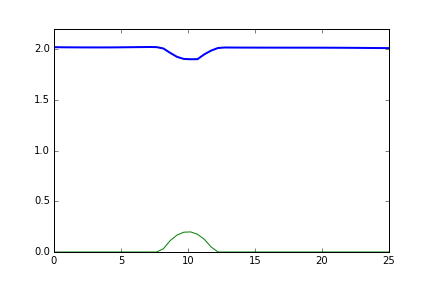
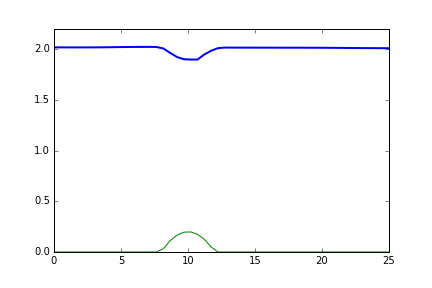
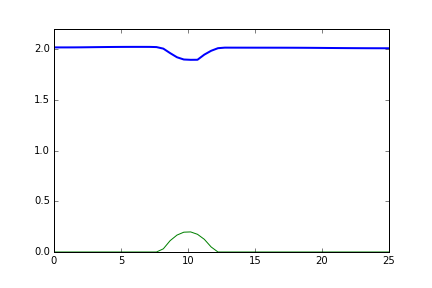

In [246]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 25), ylim=(0.0,H0*1.1))
line, = ax.plot([], [], lw=2)
lineb, = ax.plot(x,d0)

def animate(i):
    i = min(nt*4-1,i*10)
    line.set_data(x, hw[i,2:-2]+d0)
    return line,

animation.FuncAnimation(fig, animate, frames=(nt*4-1)/10, interval=45)

In [247]:
def b(x):
#     if x<=12 and x>=8:
#         return 0.2-0.05*(x-10.)**2
#     else:
#         return 0.0
    d0 = np.where((x>8)*(x<12), 0.2-0.05*(x-10.)**2, 0.0)
    return d0
def tosolve(h,x,q):
    eq = h + b(x) + q**2/(2.*9.81*h**2) - (H0+b(0)+q**2/(2.*9.81*H0**2))
    return eq

In [248]:
b(0)+H0+q0**2/(2.*9.81*H0**2)

2.2489347604485221

In [249]:
from scipy.optimize import fsolve

In [250]:
b(x)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.03132028,  0.11201583,  0.16668055,  0.19531445,
        0.19791753,  0.1744898 ,  0.12503124,  0.04954186,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [251]:
print fsolve(tosolve,2.0,args=(x[0],q0))

[ 2.]


In [252]:
ha = np.array([ fsolve(tosolve,H0,args=(x[i],q0)) for i in range(x.shape[0])])

In [253]:
ha[:,0]

array([ 2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
        2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
        2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
        2.        ,  1.95784435,  1.84412228,  1.76125838,  1.71512329,
        1.71081203,  1.74889451,  1.82490913,  1.93286516,  2.        ,
        2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
        2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
        2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
        2.        ,  2.        ,  2.        ,  2.        ,  2.        ,
        2.        ,  2.        ,  2.        ,  2.        ,  2.        ])

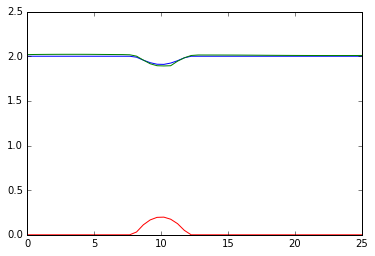

In [257]:
plt.plot(x,(ha[:,0]+d0));
plt.plot(x,hw[-1,2:-2]+d0)
plt.plot(x,d0)
